## Importing important libraries

In [1]:
#pip install py_vollib
!pip install yfinance
!pip install py_vollib

     |████████████████████████████████| 6.3MB 7.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=4d9822bac576fbd64bd50aed0eb061e2cde845e1301c7e47d5fb29afafe40f29
  Stored in directory: /root/.cache/pip/wheels/fe/a0/79/b73d4a0c535b421b88fc7b393936b371fabbfeaf979eca4050
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 133kB 7.1MB/s 
  Created wheel for py-vollib: filename=py_vollib-1.0.1-cp37-none-any.whl size=62856 sha256=88cec46ea9b9f0079580101b87c4f947c1250d525070d296ebc4ffb11f90d78c
  Stored in directory: /root/.cache/pip/wheels/31/7f/5d/abd43b8427abf03acc59e688fb8e411b8108a937398966894f
  Created wheel for py-lets-be-rational: filename=py_lets_be_rational-1.0.1-cp37-none-any.whl size=24467 sha256=56c8a9b833d74d91af4a0e6e1b0fc0a78859ca357fe223b6dd2c8d1c4fe18037
  Stored in directory: /root/.cache/pip/wh

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# to fetch data 
import yfinance as yf

import scipy.stats as ss

import py_vollib.black_scholes.greeks.analytical as derivatives

import math

# Hedging Futures Position


In this part I have coded for bull call spread on bank nifty data for 1 month managing the delta of 0.8 <br/>
Also rather than buying at the money call option, I have bought bank nifty futures at the start of the month and I will hedge it by selling OTM call option.

### Importing data

In [3]:
df_fut = pd.read_csv('/content/FUTIDX_BANKNIFTY_28-May-2021_TO_24-Jun-2021.csv')  #Fill in with the address of where file is downloaded.
df_fut.head()

,Symbol,Date,Expiry,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover in Lacs,Open Int,Change in OI,Underlying Value
0,BANKNIFTY,28-May-2021,24-Jun-2021,35499.00,35670.00,35150.00,35321.80,35394.05,35321.80,151658,1340811.02,1745000,27775,35141.45
1,BANKNIFTY,31-May-2021,24-Jun-2021,35280.00,35650.00,35063.15,35602.90,35578.25,35602.90,141916,1257088.18,1723450,-21550,-
2,BANKNIFTY,01-Jun-2021,24-Jun-2021,35677.95,35797.45,35313.95,35454.10,35470.00,35454.10,145631,1292727.92,1731125,7675,-
3,BANKNIFTY,02-Jun-2021,24-Jun-2021,35380.00,35560.00,35180.00,35524.25,35540.00,35524.25,113559,1003669.30,1700025,-31100,-
4,BANKNIFTY,03-Jun-2021,24-Jun-2021,35662.20,35890.00,35553.00,35781.95,35775.00,35781.95,121729,1086929.72,1690250,-9775,-


In [4]:
df_call_36000 = pd.read_csv('/content/36kCE_OPTIDX_BANKNIFTY_CE_28-May-2021_TO_24-Jun-2021.csv')
df_call_36000.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover in Lacs,Premium Turnover in Lacs,Open Int,Change in OI,Underlying Value
0,BANKNIFTY,28-May-2021,24-Jun-2021,CE,36000,849.95,924.50,665.60,730.80,743.30,730.80,26704,245464.26,5128.26,320700,116225,35141.45
1,BANKNIFTY,31-May-2021,24-Jun-2021,CE,36000,693.90,790.00,598.10,772.95,752.05,772.95,19525,179242.57,3517.57,331150,10450,-
2,BANKNIFTY,01-Jun-2021,24-Jun-2021,CE,36000,782.00,832.00,633.35,660.65,661.00,660.65,31536,289503.11,5679.11,313700,-17450,-
3,BANKNIFTY,02-Jun-2021,24-Jun-2021,CE,36000,575.50,625.95,533.85,612.70,606.85,612.70,19060,174293.32,2753.32,324475,10775,-
4,BANKNIFTY,03-Jun-2021,24-Jun-2021,CE,36000,659.05,753.90,596.50,698.40,696.00,698.40,24549,225062.12,4121.12,328425,3950,-


In [5]:
symbol = '^NSEBANK'
end = '2021-06-25'
start = '2021-05-28'


# Read data 
df = yf.download(symbol, start, end)

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-28,35345.648438,35436.648438,34977.199219,35141.449219,35141.449219,0
2021-05-31,35097.449219,35584.300781,34930.101562,35526.648438,35526.648438,0
2021-06-01,35639.750000,35713.898438,35241.199219,35337.199219,35337.199219,0
2021-06-02,35271.601562,35415.851562,35070.300781,35373.750000,35373.750000,0
2021-06-03,35536.449219,35723.699219,35413.000000,35649.000000,35649.000000,0


### Calculation of annual volatility and time remainig for expiry used in calculation of delta

In [6]:
symbol = '^NSEBANK'
end = '2021-05-28'
start = '2020-05-28'


# Read data 
df_year = yf.download(symbol, start, end)

df_year.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-21,33559.800781,34694.449219,33559.750000,34606.898438,34606.898438,0
2021-05-24,34869.300781,35216.101562,34528.300781,34943.601562,34943.601562,0
2021-05-25,35095.000000,35125.851562,34410.398438,34662.000000,34662.000000,0
2021-05-26,34757.148438,34897.949219,34462.500000,34684.199219,34684.199219,0
2021-05-27,34664.199219,35220.800781,34529.699219,35095.050781,35095.050781,0


In [7]:
ret = df_year['Close'].pct_change()[1:]

In [8]:
ret.head()

Date
2020-05-29    0.006648
2020-06-01    0.034339
2020-06-02    0.028572
2020-06-03    0.019995
2020-06-04   -0.026277
Name: Close, dtype: float64

In [9]:
daily_vol = ret.std()
daily_vol

0.018580334637206992

In [10]:
vol = daily_vol*252**0.5
vol

0.2949536683584554

In [11]:
expiry = datetime.strptime('2021-06-24', '%Y-%m-%d')   #Expiry date

In [12]:
time = expiry-df.index    #Time left in days
time

TimedeltaIndex(['27 days', '24 days', '23 days', '22 days', '21 days',
                '20 days', '17 days', '16 days', '15 days', '14 days',
                '13 days', '10 days',  '9 days',  '8 days',  '7 days',
                 '6 days',  '3 days',  '2 days',  '1 days',  '0 days'],
               dtype='timedelta64[ns]', name='Date', freq=None)

In [13]:
time = pd.to_timedelta(time, errors='coerce').days  #Time left in days converted to int data type
time

Int64Index([27, 24, 23, 22, 21, 20, 17, 16, 15, 14, 13, 10, 9, 8, 7, 6, 3, 2,
            1, 0],
           dtype='int64', name='Date')

### Initial buying and selling

In [14]:
no_of_lots_fut = 10           #number of future lots I bought at start of the month
buy_avg_future = df_fut['Open'][0]       #buying average of that lot
lot_size = 25     #lot size of bank nifty
delta = 1*no_of_lots_fut*lot_size    #taking delta of future is 1 as if banknifty changes by 1 the future would also change by 1
delta_to_maintain = 0.8*no_of_lots_fut*lot_size    #I will maintain 0.8 delta per future contract

In [15]:
flag = 'c'   #for call or put option
S = df['Open'][0]    #price of the underlying
K = 36000   #strike price
t = time[0]/365   #time left to expiry in years
sigma = vol   #volatility
r = 0.06  #risk free rate
delta_per_lot_call = derivatives.delta(flag, S, K, t, r, sigma)*lot_size   #to calculate delta per lot
delta_per_lot_call

11.175180281228103

In [16]:
delta_to_maintain

200.0

In [17]:
delta

250

In [18]:
number_of_lots_call = math.ceil((delta-delta_to_maintain)/delta_per_lot_call)  #number of call lots I have to sell to keep delta of 200

In [19]:
number_of_lots_call

5

In [20]:
sell_avg_call = df_call_36000['Open'][0]  #selling avg of call 
sell_avg_call

849.95

### Managing delta

In [21]:
number_of_lots_call = math.ceil((delta-delta_to_maintain)/delta_per_lot_call)  #number of call lots I have to sell to keep delta of 200
sell_avg_call = df_call_36000['Open'][0]  #selling avg of call 
profit= []

for i in range(len(df)-1):
    delta_per_lot_call = derivatives.delta(flag, df['Close'][i], 36000, time[i]/365, r, sigma)*lot_size  #Calculation of delta per lot at the next closing day
    current_number_of_lots_call = math.ceil((delta-delta_to_maintain)/delta_per_lot_call)   #number of lots required to sell
    no_of_lots_added = current_number_of_lots_call - number_of_lots_call   #number of lots added/subtracted for selling
    sell_avg_call = (sell_avg_call*number_of_lots_call + no_of_lots_added*df_call_36000['Close'][i])/current_number_of_lots_call  #new selling avg of call
    number_of_lots_call = current_number_of_lots_call    #updating number of lots of calls sold
    profit.append((df_fut['Close'][i]-buy_avg_future)*no_of_lots_fut*lot_size + (sell_avg_call-df_call_36000['Close'][i])*lot_size*number_of_lots_call)  #unrealised profit 

In [22]:
number_of_lots_call

429

In [23]:
sell_avg_call

20.093822843822842

In [24]:
delta_per_lot_call

0.1166812047191243

In [25]:
profit

[-29406.24999999926,
 35600.000000000364,
 12437.499999999643,
 35968.75,
 89681.24999999927,
 39975.00000000001,
 69912.49999999927,
 4175.00000000072,
 -62645.000000000364,
 9101.249999999622,
 -5668.750000000378,
 -21171.250000000364,
 39702.50000000038,
 -8762.50000000035,
 -95720.0000000007,
 -109927.49999999997,
 -29100.00000000032,
 -58271.24999999923,
 -93141.24999999967]

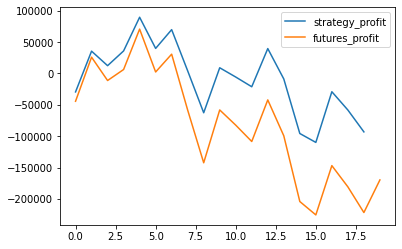

In [26]:
plt.plot(profit, label = 'strategy_profit')
plt.plot((df_fut['Close']-df_fut['Open'][0])*250, label = 'futures_profit')
plt.legend()

As you can see from the above graph of the strategy that though the futures did fall very down, I was able to hedge this with selling of call option and our strategy did give better returns overall<br/>

# Short strangle with delta hedging

I will only use 35000 puts and calls for this strategy.<br/>
Initially I will sell 10 lots of puts and correspondingly sell x lots of calls such that the delta becomes 0.<br/>
Then manage the delta accordingly by just selling or buying call options and not changing the number of put options sold.<br/>
Also, I will plot the profit graph on whole data and see the results.<br/>

### Importing data

In [27]:
df_call_35000 = pd.read_csv('/content/35kCE_OPTIDX_BANKNIFTY_CE_28-May-2021_TO_24-Jun-2021_1.csv')
df_call_35000.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover in Lacs,Premium Turnover in Lacs,Open Int,Change in OI,Underlying Value
0,BANKNIFTY,28-May-2021,24-Jun-2021,CE,35000,1394.65,1459.5,1132.0,1213.55,1224.50,1213.55,18138,164479.84,5772.34,283425,39000,35141.45
1,BANKNIFTY,31-May-2021,24-Jun-2021,CE,35000,1197.95,1339.0,1021.6,1308.30,1281.95,1308.30,14456,130864.56,4374.56,245275,-38150,-
2,BANKNIFTY,01-Jun-2021,24-Jun-2021,CE,35000,1291.90,1398.0,1112.3,1155.05,1163.00,1155.05,15231,137967.95,4696.70,345025,99750,-
3,BANKNIFTY,02-Jun-2021,24-Jun-2021,CE,35000,1099.30,1145.7,982.5,1128.05,1122.00,1128.05,12258,110507.46,3249.96,342375,-2650,-
4,BANKNIFTY,03-Jun-2021,24-Jun-2021,CE,35000,1163.20,1342.5,1111.7,1265.45,1270.00,1265.45,7511,68025.76,2304.51,307825,-34550,-


In [28]:
df_put_35000 = pd.read_csv('/content/35kPE_OPTIDX_BANKNIFTY_PE_28-May-2021_TO_24-Jun-2021.csv')
df_put_35000.head()

,Symbol,Date,Expiry,Option Type,Strike Price,Open,High,Low,Close,LTP,Settle Price,No. of contracts,Turnover in Lacs,Premium Turnover in Lacs,Open Int,Change in OI,Underlying Value
0,BANKNIFTY,28-May-2021,24-Jun-2021,PE,35000,940.00,984.85,820.20,907.15,856.0,907.15,30957,277944.81,7071.06,217275,-3850,35141.45
1,BANKNIFTY,31-May-2021,24-Jun-2021,PE,35000,886.00,975.50,690.45,706.40,713.9,706.40,22393,200373.31,4434.56,215875,-1400,-
2,BANKNIFTY,01-Jun-2021,24-Jun-2021,PE,35000,682.35,795.25,605.40,701.25,697.0,701.25,22207,198214.51,3903.26,245775,29900,-
3,BANKNIFTY,02-Jun-2021,24-Jun-2021,PE,35000,747.50,799.95,581.80,601.55,587.7,601.55,18375,164002.20,3220.95,235300,-10475,-
4,BANKNIFTY,03-Jun-2021,24-Jun-2021,PE,35000,486.50,564.00,447.15,484.85,489.0,484.85,19913,176748.22,2509.47,217500,-17800,-


### Initialising everything required to calculate delta

In [29]:
#Assume I am starting the strategy at the opening time of 28th May
S = df['Open'][0]    #price of the underlying
K = 35000   #strike price
t = time[0]/365   #time left to expiry in years
sigma = vol   #volatility
r = 0.06  #risk free rate
delta_to_maintain = 0

### Initial selling

In [30]:
no_of_lots_put = 10      #number of lots of put sold
sell_avg_put = df_put_35000['Open'][0]   #selling average of seeling those lots
lot_size = 25
delta = derivatives.delta('p', S, K, t, r, sigma)*no_of_lots_put*lot_size  #total delta after selling 250 quantities of put

In [31]:
delta

-103.43461645722918

In [32]:
delta_per_lot_call = derivatives.delta('c', S, K, t, r, sigma)*lot_size  #delta per lot of call,i.e, delta of 25 quantities
delta_per_lot_call

14.656538354277082

In [33]:
number_of_lots_call = math.ceil((delta_to_maintain-delta)/delta_per_lot_call)   #number of lots of call to be sold
number_of_lots_call

8

In [34]:
sell_avg_call = df_call_35000['Open'][0]   #selling average of that call options sold
sell_avg_call

1394.65

### Delta Management

In [35]:
number_of_lots_call =  math.ceil((delta_to_maintain-delta)/delta_per_lot_call)   #number of call lots to be sold
sell_avg_call = df_call_35000['Open'][0]   #selling average
profit = []

#Write the code for delta management
for i in range(len(df)-1):
    #Calculation of delta per lot at the next closing day
    delta_per_lot_call = derivatives.delta('c', df['Close'][i], 35000, time[i]/365, r, sigma)*lot_size
    delta_per_lot_put = derivatives.delta('p', df['Close'][i], 35000, time[i]/365, r, sigma)*lot_size

    #Calculation of delta of puts
    delta = no_of_lots_put*delta_per_lot_put

    current_number_of_lots_call = math.ceil((delta_to_maintain-delta)/delta_per_lot_call)  #number of lots required to sell
    no_of_lots_added = current_number_of_lots_call - number_of_lots_call   #number of lots added/subtracted for selling
    sell_avg_call = (sell_avg_call*number_of_lots_call + no_of_lots_added*df_call_35000['Close'][i])/current_number_of_lots_call  #new selling avg of call
    number_of_lots_call = current_number_of_lots_call
    profit.append((sell_avg_put-df_put_35000['Close'][i])*lot_size*no_of_lots_put + (sell_avg_call-df_call_35000['Close'][i])*lot_size*number_of_lots_call)

In [36]:
profit.append((sell_avg_put-df_put_35000['Close'][len(df)-1])*lot_size*no_of_lots_put + (sell_avg_call-df_call_35000['Close'][len(df)-1])*lot_size*number_of_lots_call)  #profit at the expiry as at expiry delta is not done and therefore cannot be calculated in the above loop

In [37]:
profit

[44432.50000000004,
 75670.00000000006,
 103776.25000000003,
 134101.25000000006,
 139231.25,
 155336.25,
 173938.75000000006,
 204183.75,
 212380.0,
 215035.00000000003,
 239940.0,
 267456.25,
 274581.25000000006,
 281151.25,
 303076.25,
 332570.00000000006,
 369955.0,
 391562.5,
 416448.75,
 522823.75000000006]

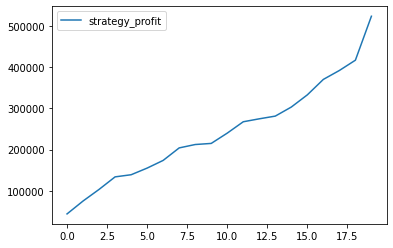

In [38]:
#Plot the profit graph
plt.plot(profit, label = 'strategy_profit')
plt.legend()

See the results you get by selling calls and puts and just managing delta at end of day